In [1]:
import pandas as pd
from lib.data_utils import fetch_and_prepare_data

sample_size = 10_000

try:
    data_df = pd.read_csv('data_samples/paragraph-questions-10k.csv')
    print('Dataset already exists.')
except FileNotFoundError:
    data_df = await fetch_and_prepare_data(sample_size)
    data_df.to_csv('data_samples/paragraph-questions-10k.csv', index=False)

data_df.head()

Dataset already exists.


,_sa_instance_state_question,paragraph_id,text_question,scope,timestamp,downvote,context,id_question,author_id,upvote,...,setting,id_answer,text,_sa_instance_state_rating,text_rating,author_id_rating,value,answer_id,id_rating,timestamp_rating
0,<sqlalchemy.orm.state.InstanceState object at ...,232496,What was the purpose of the Shadow factory pla...,single-paragraph,2024-05-01 01:02:34,0,"In an article about 'Supermarine Spitfire', se...",72727,8,0,...,ic,144600,"The purpose of the Shadow factory plan, initia...",<sqlalchemy.orm.state.InstanceState object at ...,The answer accurately summarizes the purpose o...,7,5,144600,144484,2024-05-01 01:02:47
1,<sqlalchemy.orm.state.InstanceState object at ...,232496,What was the purpose of the Shadow factory pla...,single-paragraph,2024-05-01 01:02:34,0,"In an article about 'Supermarine Spitfire', se...",72727,8,0,...,ic,144617,"The purpose of the Shadow factory plan, initia...",<sqlalchemy.orm.state.InstanceState object at ...,The answer accurately summarizes the purpose o...,7,5,144617,144501,2024-05-01 01:02:59
2,<sqlalchemy.orm.state.InstanceState object at ...,105156,What criticism has the Hawker Siddeley Harrier...,single-paragraph,2024-05-01 01:03:38,0,"In an article about 'Hawker Siddeley Harrier',...",72781,8,0,...,ic,144684,The Hawker Siddeley Harrier has faced criticis...,<sqlalchemy.orm.state.InstanceState object at ...,"This answer is fully accurate and detailed, pr...",7,5,144684,144569,2024-05-01 01:03:51
3,<sqlalchemy.orm.state.InstanceState object at ...,105156,What criticism has the Hawker Siddeley Harrier...,single-paragraph,2024-05-01 01:03:38,0,"In an article about 'Hawker Siddeley Harrier',...",72781,8,0,...,ic,144701,The Hawker Siddeley Harrier has faced criticis...,<sqlalchemy.orm.state.InstanceState object at ...,"This answer is fully accurate and detailed, pr...",7,5,144701,144586,2024-05-01 01:04:04
4,<sqlalchemy.orm.state.InstanceState object at ...,37828,On what date did Jon Lieber throw his first ma...,single-paragraph,2024-05-01 01:04:25,0,"In an article about 'Jon Lieber', section 'Bio...",72805,8,0,...,ic,144744,Jon Lieber threw his first major league shutou...,<sqlalchemy.orm.state.InstanceState object at ...,The answer provided is fully accurate and deta...,7,5,144744,144628,2024-05-01 01:04:36


In [2]:
from lib.llm_utils import generate_and_rate_answers
from fleecekmbackend.core.config import DATABASE_URL
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker

engine = create_async_engine(DATABASE_URL, echo=False)
async_session = sessionmaker(engine, expire_on_commit=False, class_=AsyncSession)


questions = data_df[['id_question', 'paragraph_id', 'text_question']].rename(columns={
        'id_question': 'id',
        'paragraph_id': 'paragraph_id',
        'text_question': 'text'
    }).head(100).to_dict(orient='records')

async with async_session() as session:
    results_df = await generate_and_rate_answers(session, questions)
results_df.to_csv('data_samples/paragraph-questions-10k-short-answers.csv', index=False)
results_df


  0%|          | 0/100 [00:00<?, ?it/s]

,question_id,short_answer_id,short_answer_text,five_word_answer_id,five_word_answer_text,short_answer_rating_id,five_word_answer_rating_id,short_answer_rating_score,five_word_answer_rating_score,short_answer_rating_rationale,five_word_answer_rating_rationale
0,72727,2192552,To boost British aircraft production capacity.,2192553,Boost British aircraft production.,2192346,2192349,4,4,"The answer ""To boost British aircraft producti...","The answer ""Boost British aircraft production""..."
1,72727,2192561,To boost British aircraft production capacity.,2192562,Boost British aircraft production.,2192356,2192359,4,4,"The answer ""To boost British aircraft producti...","The answer ""Boost British aircraft production""..."
2,72781,2192568,High accident rate and challenging maintenance.,2192569,High accident rate.,2192362,2192364,4,4,The answer provided accurately summarizes two ...,"The answer ""High accident rate"" is mostly corr..."
3,72781,2192575,High accident rate and challenging maintenance.,2192576,High accident rate.,2192368,2192371,4,4,The answer provided accurately summarizes two ...,"The answer ""High accident rate"" is mostly corr..."
4,72805,2192581,"May 14, against the Atlanta Braves.",2192582,"May 14, vs. Atlanta Braves.",2192374,2192375,5,5,The answer provided exactly matches the inform...,The answer provided exactly matches the inform...
...,...,...,...,...,...,...,...,...,...,...,...
95,73343,2193298,The rifle units' battle formation was less str...,2193300,"Less structured, more adaptable.",2193092,2193097,5,4,"This answer is fully accurate and detailed, pr...","The answer ""Less structured, more adaptable"" a..."
96,73344,2193308,"The answer is ""Super"".",2193310,The Spider's Web.,2193103,2193106,2,2,"The answer ""The answer is 'Super'"" is partiall...","The answer ""The Spider's Web"" is partially cor..."
97,73344,2193317,"The answer is ""Super"".",2193319,The Spider's Web.,2193111,2193114,2,2,"The answer ""The answer is 'Super'"" is partiall...","The answer ""The Spider's Web"" is partially cor..."
98,73345,2193323,"She performs a ""Super"" (likely referring to a ...",2193324,She performs a splash.,2193116,2193119,4,4,The answer is mostly correct as it provides a ...,"The answer ""She performs a splash"" is mostly c..."


Average short answer length: 4.9
Average five-word answer length: 3.07
Number of short answers under 5 words: 68
Mean short answer rating score: 4.84
Variance short answer rating score: 0.256969696969697
Mean five-word answer rating score: 4.76
Variance five-word answer rating score: 0.3054545454545455
Number of entries where rating score > 3: 98
Ratio of entries where rating score > 3: 0.98
Sampled filtered entries where rating score > 3:
   question_id short_answer_id  \
22       73075         2192692   
33       73181         2192774   
56       73324         2192957   
27       73077         2192717   
3        72781         2192575   

                                    short_answer_text five_word_answer_id  \
22        The High Seas Fleet's reconnaissance force.             2192693   
33                                 Smoking cessation.             2192775   
56  Hamburg was sunk by British bombers in 1944 an...             2192959   
27                                       HM

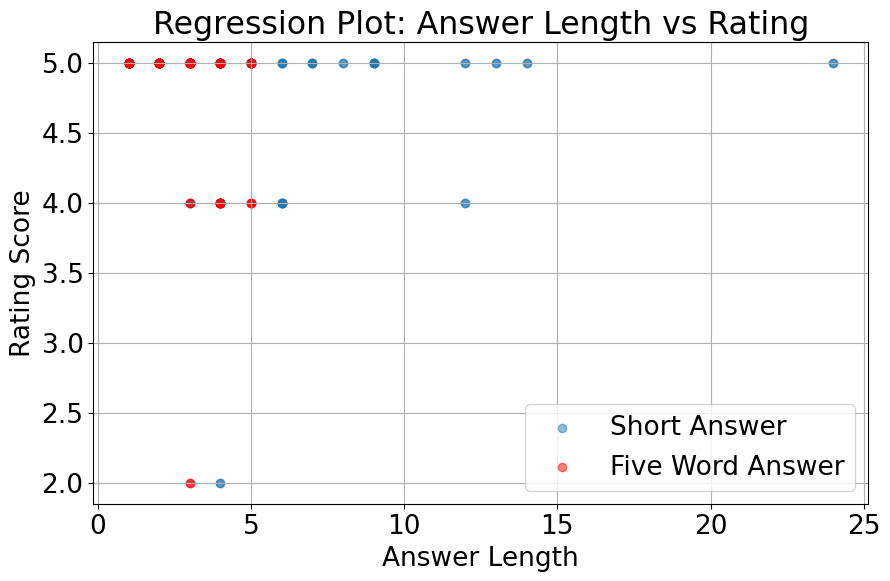

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


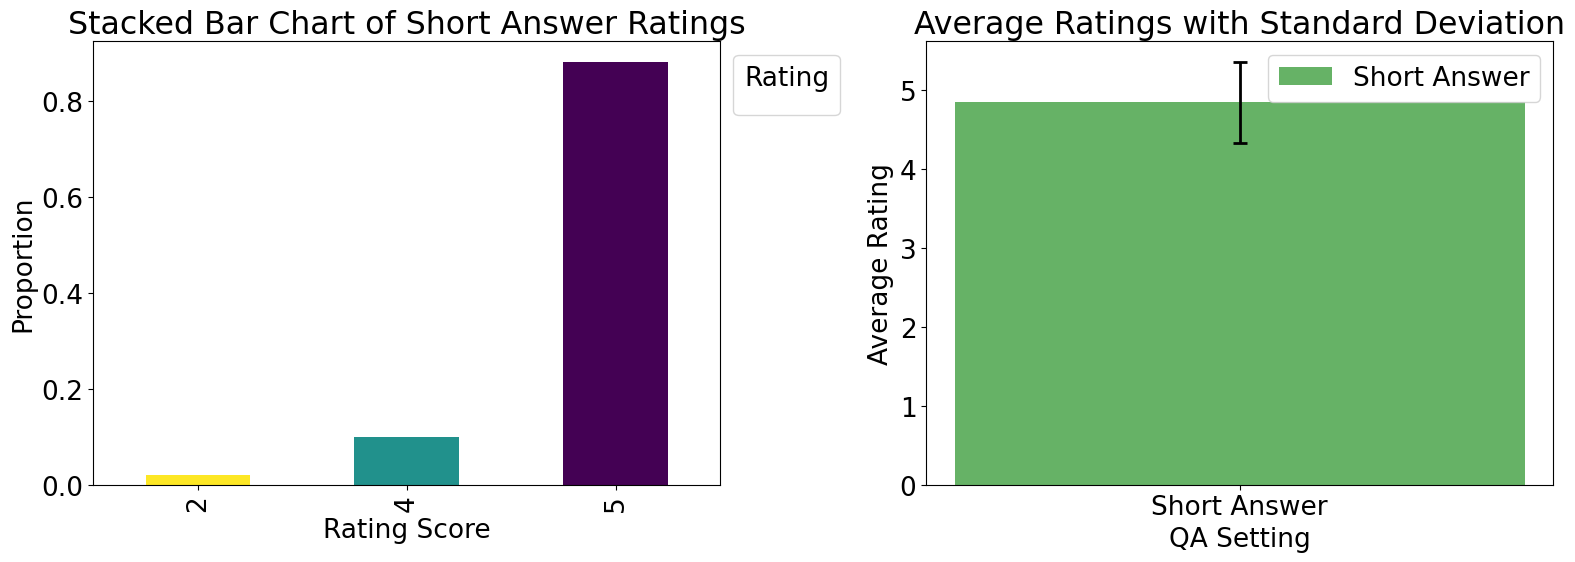

In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
average_short_answer_length = results_df['short_answer_text'].str.split().str.len().mean()
average_five_word_answer_length = results_df['five_word_answer_text'].str.split().str.len().mean()
number_short_answers_under_5_words = (results_df['short_answer_text'].str.split().str.len() <= 5).sum()
mean_short_answer_rating_score = results_df['short_answer_rating_score'].mean()
variance_short_answer_rating_score = results_df['short_answer_rating_score'].var()

mean_five_word_answer_rating_score = results_df['five_word_answer_rating_score'].mean()
variance_five_word_answer_rating_score = results_df['five_word_answer_rating_score'].var()

# Filter entries where the score > 3
filtered_results = results_df[(results_df['short_answer_rating_score'] > 3) | (results_df['five_word_answer_rating_score'] > 3)]
number_filtered_entries = filtered_results.shape[0]
ratio_filtered_entries = number_filtered_entries / results_df.shape[0]

# Randomly sample entries where the score > 3 and print them
sampled_filtered_entries = filtered_results.sample(5)

# Print statistics
print(f"Average short answer length: {average_short_answer_length}")
print(f"Average five-word answer length: {average_five_word_answer_length}")
print(f"Number of short answers under 5 words: {number_short_answers_under_5_words}")
print(f"Mean short answer rating score: {mean_short_answer_rating_score}")
print(f"Variance short answer rating score: {variance_short_answer_rating_score}")
print(f"Mean five-word answer rating score: {mean_five_word_answer_rating_score}")
print(f"Variance five-word answer rating score: {variance_five_word_answer_rating_score}")
print(f"Number of entries where rating score > 3: {number_filtered_entries}")
print(f"Ratio of entries where rating score > 3: {ratio_filtered_entries}")

print("Sampled filtered entries where rating score > 3:")
print(sampled_filtered_entries)

# Plotting regression plot between length of answer and answer rating
results_df['short_answer_length'] = results_df['short_answer_text'].str.split().str.len()
results_df['five_word_answer_length'] = results_df['five_word_answer_text'].str.split().str.len()

plt.figure(figsize=(10, 6))
plt.scatter(results_df['short_answer_length'], results_df['short_answer_rating_score'], alpha=0.5, label='Short Answer')
plt.scatter(results_df['five_word_answer_length'], results_df['five_word_answer_rating_score'], alpha=0.5, label='Five Word Answer', color='r')
plt.title('Regression Plot: Answer Length vs Rating')
plt.xlabel('Answer Length')
plt.ylabel('Rating Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot stacked bar chart and mean-variance chart
def plot_model_results(data):
    unique_ratings = data['short_answer_rating_score'].nunique()
    colors = plt.cm.viridis(np.linspace(1, 0, unique_ratings))

    plt.rcParams.update({'font.size': 19})

    # Initialize subplot for two graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalize and plot 100% Stacked Bar Chart for short answers
    counts = data.groupby(['short_answer_rating_score']).size()
    proportions = counts / counts.sum()
    proportions.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
    axes[0].set_title(f'Stacked Bar Chart of Short Answer Ratings')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xlabel('Rating Score')
    axes[0].legend(title='Rating', bbox_to_anchor=(1.0, 1.0), reverse=True)

    # Bar graph of average ratings with variance as error bars for short answers
    index = np.arange(1) 
    bar_width = 0.35
    error_config = {'capsize': 5, 'elinewidth': 2, 'markeredgewidth': 2}

    # Get means and variances
    means_short = data['short_answer_rating_score'].mean()
    variances_short = data['short_answer_rating_score'].var()

    # Bars for short answers
    axes[1].bar(index, means_short, bar_width, yerr=np.sqrt(variances_short), label='Short Answer',
                error_kw=error_config, color='green', alpha=0.6)

    axes[1].set_xlabel('QA Setting')
    axes[1].set_ylabel('Average Rating')
    axes[1].set_title('Average Ratings with Standard Deviation')
    axes[1].set_xticks(index)
    axes[1].set_xticklabels(['Short Answer'])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_model_results(results_df)

Average short answer length: 4.9
Number of short answers under 5 words: 68
Mean short answer rating score: 4.84
Variance short answer rating score: 0.256969696969697
Mean five-word answer rating score: 4.76
Variance five-word answer rating score: 0.3054545454545455
Number of entries where rating score < 3: 2
Ratio of entries where rating score < 3: 0.02
Sampled filtered entries where rating score < 3:
   question_id short_answer_id       short_answer_text five_word_answer_id  \
97       73344         2193317  The answer is "Super".             2193319   
96       73344         2193308  The answer is "Super".             2193310   

   five_word_answer_text short_answer_rating_id five_word_answer_rating_id  \
97     The Spider's Web.                2193111                    2193114   
96     The Spider's Web.                2193103                    2193106   

   short_answer_rating_score five_word_answer_rating_score  \
97                         2                             2   
9

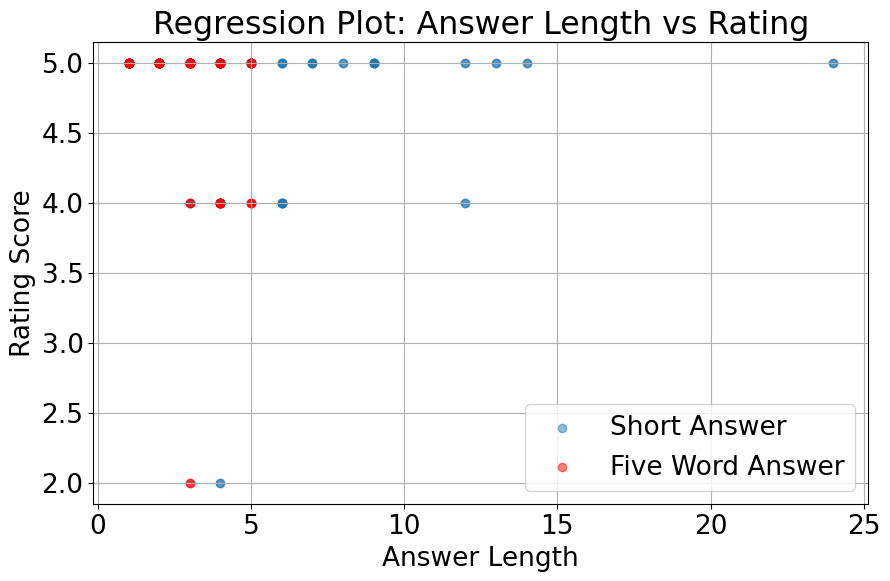

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


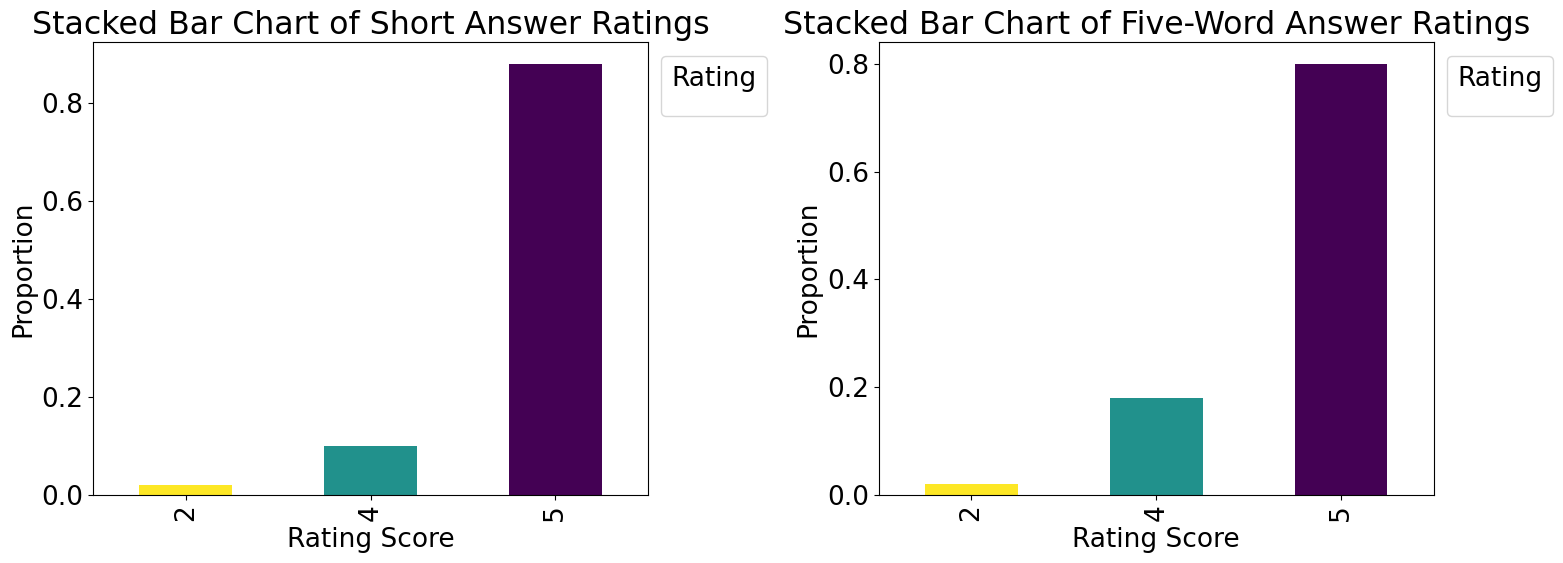

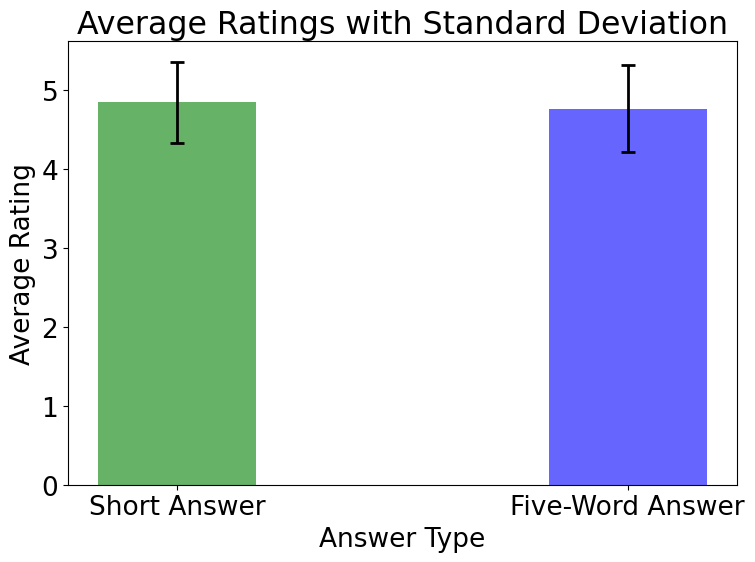

In [50]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
average_short_answer_length = results_df['short_answer_text'].str.split().str.len().mean()
number_short_answers_under_5_words = (results_df['short_answer_text'].str.split().str.len() <= 5).sum()
mean_short_answer_rating_score = results_df['short_answer_rating_score'].mean()
variance_short_answer_rating_score = results_df['short_answer_rating_score'].var()

mean_five_word_answer_rating_score = results_df['five_word_answer_rating_score'].mean()
variance_five_word_answer_rating_score = results_df['five_word_answer_rating_score'].var()

# Filter entries where the score > 3
filtered_results = results_df[(results_df['short_answer_rating_score'] < 3) | (results_df['five_word_answer_rating_score'] < 3)]
number_filtered_entries = filtered_results.shape[0]
ratio_filtered_entries = number_filtered_entries / results_df.shape[0]

# Randomly sample entries where the score > 3 and print them
sampled_filtered_entries = filtered_results.sample(2)

# Print statistics
print(f"Average short answer length: {average_short_answer_length}")
print(f"Number of short answers under 5 words: {number_short_answers_under_5_words}")
print(f"Mean short answer rating score: {mean_short_answer_rating_score}")
print(f"Variance short answer rating score: {variance_short_answer_rating_score}")
print(f"Mean five-word answer rating score: {mean_five_word_answer_rating_score}")
print(f"Variance five-word answer rating score: {variance_five_word_answer_rating_score}")
print(f"Number of entries where rating score < 3: {number_filtered_entries}")
print(f"Ratio of entries where rating score < 3: {ratio_filtered_entries}")

print("Sampled filtered entries where rating score < 3:")
print(sampled_filtered_entries)

# Plotting regression plot between length of answer and answer rating
results_df['short_answer_length'] = results_df['short_answer_text'].str.split().str.len()
results_df['five_word_answer_length'] = results_df['five_word_answer_text'].str.split().str.len()

plt.figure(figsize=(10, 6))
plt.scatter(results_df['short_answer_length'], results_df['short_answer_rating_score'], alpha=0.5, label='Short Answer')
plt.scatter(results_df['five_word_answer_length'], results_df['five_word_answer_rating_score'], alpha=0.5, label='Five Word Answer', color='r')
plt.title('Regression Plot: Answer Length vs Rating')
plt.xlabel('Answer Length')
plt.ylabel('Rating Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot stacked bar chart and mean-variance chart
def plot_model_results(data):
    unique_ratings_short = data['short_answer_rating_score'].nunique()
    unique_ratings_five_word = data['five_word_answer_rating_score'].nunique()
    max_unique_ratings = max(unique_ratings_short, unique_ratings_five_word)
    colors = plt.cm.viridis(np.linspace(1, 0, max_unique_ratings))

    plt.rcParams.update({'font.size': 19})

    # Initialize subplot for two graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalize and plot 100% Stacked Bar Chart for short answers
    counts_short = data.groupby(['short_answer_rating_score']).size()
    proportions_short = counts_short / counts_short.sum()
    proportions_short.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
    axes[0].set_title(f'Stacked Bar Chart of Short Answer Ratings')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xlabel('Rating Score')
    axes[0].legend(title='Rating', bbox_to_anchor=(1.0, 1.0), reverse=True)

    # Normalize and plot 100% Stacked Bar Chart for five-word answers
    counts_five_word = data.groupby(['five_word_answer_rating_score']).size()
    proportions_five_word = counts_five_word / counts_five_word.sum()
    proportions_five_word.plot(kind='bar', stacked=True, color=colors, ax=axes[1])
    axes[1].set_title(f'Stacked Bar Chart of Five-Word Answer Ratings')
    axes[1].set_ylabel('Proportion')
    axes[1].set_xlabel('Rating Score')
    axes[1].legend(title='Rating', bbox_to_anchor=(1.0, 1.0), reverse=True)

    plt.tight_layout()
    plt.show()

    # Plot bar graph of average ratings with variance as error bars for short answers and five-word answers
    fig, ax = plt.subplots(figsize=(8, 6))
    index = np.arange(2)
    bar_width = 0.35
    error_config = {'capsize': 5, 'elinewidth': 2, 'markeredgewidth': 2}

    # Get means and variances
    means = [data['short_answer_rating_score'].mean(), data['five_word_answer_rating_score'].mean()]
    variances = [data['short_answer_rating_score'].var(), data['five_word_answer_rating_score'].var()]

    # Bars for short answers and five-word answers
    ax.bar(index, means, bar_width, yerr=np.sqrt(variances), error_kw=error_config, color=['green', 'blue'], alpha=0.6)

    ax.set_xlabel('Answer Type')
    ax.set_ylabel('Average Rating')
    ax.set_title('Average Ratings with Standard Deviation')
    ax.set_xticks(index)
    ax.set_xticklabels(['Short Answer', 'Five-Word Answer'])

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_model_results(results_df)


In [48]:
sampled_filtered_entries[['five_word_answer_rating_rationale']].values[0][0]

'The answer "The Spider\'s Web" is partially correct because it is a signature move of Lisa Marie Varon, but it does not fully match the description provided in the fact. The fact mentions that the move involves jumping onto an oncoming opponent, but it does not specifically mention "The Spider\'s Web". Therefore, while the answer is related to Lisa Marie Varon\'s moveset, it lacks accuracy and completeness in describing the specific move being referred to. A more accurate answer would be "Super", as mentioned in the fact, but without further information, it is unclear what type of move "Super" refers to.'

In [43]:
import pandas as pd
from sqlalchemy.sql import select
from fleecekmbackend.db.models import Question, Paragraph

async def fetch_question_paragraph_info(question_ids):
    async with async_session() as session:
        question_query = select(Question).where(Question.id.in_(question_ids))
        paragraph_query = select(Paragraph).where(Paragraph.id.in_(question_ids))

        question_results = await session.execute(question_query)
        paragraph_results = await session.execute(paragraph_query)

        questions = question_results.scalars().all()
        paragraphs = paragraph_results.scalars().all()

        print(f"Fetched {questions[0].text} questions and {paragraphs[0].text} paragraphs.")

        question_df = pd.DataFrame([q.__dict__ for q in questions])
        paragraph_df = pd.DataFrame([p.__dict__ for p in paragraphs])

        return question_df, paragraph_df

unique_question_ids = sampled_filtered_entries['question_id'].unique()
question_df, paragraph_df = await fetch_question_paragraph_info(unique_question_ids)

# Merge question and paragraph information with results DataFrame
sampled_filtered_entries = sampled_filtered_entries.merge(question_df, left_on='question_id', right_on='id', suffixes=('', '_question'))
sampled_filtered_entries = sampled_filtered_entries.merge(paragraph_df, left_on='paragraph_id', right_on='id', suffixes=('', '_paragraph'))

Fetched What is a signature move often used by Lisa Marie Varon, which involves jumping onto an oncoming opponent? questions and The innings was interrupted by bad light and upon the resumption of proceedings , poor visibility intervened for a second time with Compton on 97 . After 55 minutes of delay , the umpires called the players back onto the field . Wisden said : " rarely can a Test Match have been played under such appalling conditions as on this day . " Fingleton said the conditions were " pitiable " and lamented the " utmost gloom in which batsmen and fieldsmen had intense difficulty in sighting the ball " . O 'Reilly said it was " without doubt the worst light " under which he had seen a first-class match proceed . Compton brought up his third consecutive century at Trent Bridge by hitting a single to square leg , a " lovely century of stroke-play and patience " according to Fingleton . The innings had taken 227 minutes and included 12 fours , and Compton had regularly hit th

,question_id,short_answer_id,short_answer_text,five_word_answer_id,five_word_answer_text,short_answer_rating_id,five_word_answer_rating_id,short_answer_rating_score,five_word_answer_rating_score,short_answer_rating_rationale,...,subsubsection_name,section_hierarchy,word_count,within_page_order,page_name,section_name,text_paragraph,text_cleaned,is_bad,processed
